In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from tqdm import tqdm
import seaborn as sns

In [ ]:
    
class PriceDifferenceMap:
    def __init__(self,
                 inference_data_folder: str = 'C:/Users/nilsk/Dokumente/Machine Learning (MSc.)/1. Semester/Data Literacy/DataLit-InsideAirbnb/results/XGBoost_all_european_cities_no_cv/london_inference_data.csv',
                 resolution: int = 1000,
                 inference_location: str = "London, United Kingdom"
        ):
        inference_data = pd.read_csv(inference_data_folder)
        inference_data['price'] = inference_data['price'].replace('[\$,]', '', regex=True).astype(float).to_numpy()
        inference_data['price_difference'] = inference_data['price'] - inference_data['predictions']

        self.inference_data = inference_data

        # init city bounds
        self.city_boundary = ox.geocode_to_gdf(inference_location).to_crs(epsg=3857)

        # create grid
        xmin, ymin, xmax, ymax = self.city_boundary.total_bounds
        x_coords = np.arange(xmin, xmax, resolution)
        y_coords = np.arange(ymin, ymax, resolution)
        self.xx, self.yy = np.meshgrid(x_coords, y_coords)

        # create point df from grid
        points = gpd.GeoDataFrame(
            geometry=[Point(x, y) for x, y in zip(self.xx.flatten(), self.yy.flatten())],
            crs="EPSG:3857"
        )
        points["is_inside"] = points.within(self.city_boundary.union_all())


        points["value"] = 0.0
        points.loc[~points["is_inside"], "value"] = np.nan  


        gdf_city = gpd.GeoDataFrame(
            inference_data,
            geometry=gpd.points_from_xy(inference_data.longitude, inference_data.latitude),
            crs="EPSG:4326"
        ).to_crs(epsg=3857)


        k = 3  # number of nearest neighbours to consider
        point_list = list(points[points["is_inside"]].iterrows())
        for idx, point in tqdm(point_list):
            
            dists = gdf_city.geometry.distance(point.geometry)
            k_nearest_indices = dists.nsmallest(k).index

            points.at[idx, "value"] = gdf_city.loc[k_nearest_indices, "price_difference"].mean()

        self.grid_values = points["value"].values.reshape(self.xx.shape)

    def plot(self,
             save_folder: str = 'C:/Users/nilsk/Dokumente/Machine Learning (MSc.)/1. Semester/Data Literacy/visualization/london.png',
             cmap_lower_bound = -200,
             cmap_upper_bound = 400):
        
        sns.set_theme(style="whitegrid")  
        sns.set_context("paper", font_scale=1.2) 

        plt.rcParams.update({
            "text.usetex": True,         
            "font.family": "serif",     
            "font.serif": "ptm",         
            "font.sans-serif": "phv",     
            "text.latex.preamble": r"\usepackage{mathptmx}",  
        })

        fig, ax = plt.subplots(figsize=(12, 12))

        # custom color map
        colors = ["#0072B2", "#F0E442", "#E69F00", "#CC79A7"]
        nodes = [0.0, 0.52, 0.75, 1.0]
        customcmp = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

        # plot raster grid
        raster_plot = ax.pcolormesh(
            self.xx, self.yy, self.grid_values,
            cmap=customcmp,  # Color map
            edgecolors="none",
            alpha=0.7,
            vmin=cmap_lower_bound, vmax=cmap_upper_bound  # Value range for color scaling
        )

        # add city boundary
        self.city_boundary.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1.5)

        # add OpenStreetMap basemap
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=self.city_boundary.crs, zoom=11)

        # customize plot
        ax.set_axis_off()

        cbar = plt.colorbar(raster_plot, ax=ax, 
                        label="price difference $y - \hat{y}$", 
                        shrink=0.593, pad=0.05)
        cbar.ax.tick_params(labelsize=10)  # Match Seaborn's font scaling
    
        # Use Seaborn for title/label styling (optional)
        ax.set_title("Difference of ground truth to predicted prices in London", 
                fontsize=18, 
                fontweight='bold')  
        
        plt.savefig(save_folder, dpi=300, transparent=True)
        plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:95: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:95: SyntaxWarning: invalid escape sequence '\h'
C:\Users\nilsk\AppData\Local\Temp\ipykernel_27464\493217192.py:8: SyntaxWarning: invalid escape sequence '\$'
  inference_data['price'] = inference_data['price'].replace('[\$,]', '', regex=True).astype(float).to_numpy()
C:\Users\nilsk\AppData\Local\Temp\ipykernel_27464\493217192.py:95: SyntaxWarning: invalid escape sequence '\h'
  label="price difference $y - \hat{y}$",


In [ ]:
diff_map = PriceDifferenceMap(resolution=500)

 10%|▉         | 1578/16398 [00:27<02:27, 100.78it/s]

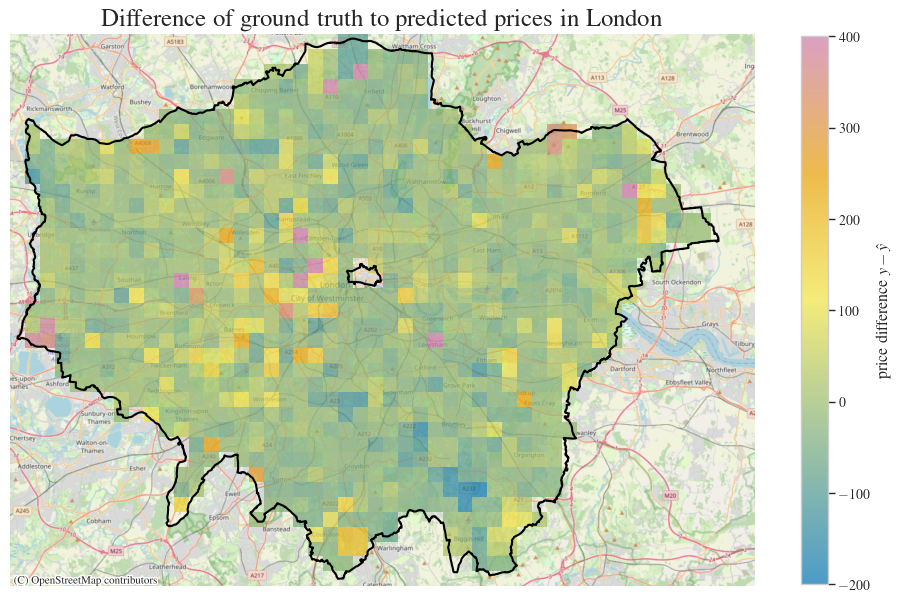

In [29]:
diff_map.plot()